# BERT Fine Tuning (Transfer Learning)

## Overview

Step by step using BERT fine tuning with Hugginfac DistilBert base model.

## Dependency

Using the data for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Download **jigsaw-toxic-comment-classification-challenge.zip** and place it in the directory pointed by the **DATA_DIR** variable.

## Limitations

The [save_pretrained](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.save_pretrained) method of the Huggingface Model class cannot be used on the fine-tuned model.

## References

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

* [Training TFBertForSequenceClassification with custom X and Y data](https://stackoverflow.com/a/63295240/4281353)

---
# Setups

In [1]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Constants

In [2]:
# To reduce the data volume to run through the training in short timeframe.
TEST_MODE = False
NUM_TEST_SAMPLES = 1000

# --------------------------------------------------------------------------------
## Execution recording (e.g. 2021JUL012322)
# --------------------------------------------------------------------------------
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.") 
print(f"Execution timestamp {TIMESTAMP}")

# --------------------------------------------------------------------------------
# Directory to manage the data. 
# --------------------------------------------------------------------------------
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."      # Directory where immutable files are located
BASE_DIR = "."      # Home directory of the project
OUTPUT_DIR = BASE_DIR + os.path.sep + "output"   # Directory to save mutable files.

# --------------------------------------------------------------------------------
# Data Labels that classifies the type of the comment.
# --------------------------------------------------------------------------------
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Target category
CATEGORY = "toxic"

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# --------------------------------------------------------------------------------
# HuggingFace
# --------------------------------------------------------------------------------
MAX_SEQUENCE_LENGTH = 256   # Max token length to accept. 512 taks 1 hour/epoch on Google Colab
MODEL_NAME = 'distilbert-base-uncased'

# --------------------------------------------------------------------------------
# Model
# --------------------------------------------------------------------------------
NUM_CLASSES = 1    # Number of classes/categories to classify
TARGET_LABEL_INDEX = 0 if NUM_CLASSES == 1 else 1

# Flag to freeze base model
FREEZE_BASE_MODEL = False

# Flag to add Dense(softmax) on top
USE_SOFTMAX_LAYER = True

# Flag to add custom classification layers on top of the base
USE_CLASSIFICATION_LAYER = False
if USE_CLASSIFICATION_LAYER == False:
    # Base needs to be trainable with no classification head
    FREEZE_BASE_MODEL = False

    # Base model only generates logits. Hence without classification layer
    # the base output needs to go through a Dense layer to reduce the output 
    # to NUM_CLASSES classes. It is an option not to use softmax in the last 
    # Dense layer and feed logits into the loss function.
    USE_SOFTMAX_LAYER = True

# Normalized output into the loss layer without softmax
LOGITS_TO_LOSS = False if USE_SOFTMAX_LAYER else True


Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.2022MAR29
Execution timestamp 2022MAR29


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [3]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [4]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/content/drive/MyDrive/home/data/kaggle/toxic_comment_classification"
    BASE_DIR = "/content/drive/MyDrive/home/repository/mon/huggingface/finetuning"
    OUTPUT_DIR = BASE_DIR + os.path.sep + "output"
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Not using Google Colab environment.


### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [5]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    OUTPUT_DIR = "/kaggle/working"


os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [6]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install -U h5py pandas matplotlib numpy==1.20

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


## Modules

Install and load Python modules required for the task.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

In [11]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

In [12]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

In [15]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [16]:
if tf.test.is_gpu_available():
    print('Running on GPU')
    print('GPU #0?')
else:
    print('Running on CPU')

Running on GPU
GPU #0?


In [17]:
import transformers
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertModel,
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output directories

In [18]:
# Result output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

RESULT_DIRECTORY = f"{OUTPUT_DIR}/run_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")

MODEL_DIRECTORY = "{parent}/model".format(
    parent=RESULT_DIRECTORY
)
Path(MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)
MODEL_FILE = MODEL_DIRECTORY + os.path.sep + "model.h5"

LOG_DIRECTORY = "{parent}/log".format(
    parent=RESULT_DIRECTORY,
)
Path(LOG_DIRECTORY).mkdir(parents=True, exist_ok=True)

## Parameters

In [29]:
# Model training
NUM_EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-2 if FREEZE_BASE_MODEL else 5e-5
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

---
# Toxic text data

* [Toxic Comment Classification Challenge](jigsaw-toxic-comment-classification-challenge)

> You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. 

In [19]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

Enter the data archive path./data/jigsaw-toxic-comment-classification-challenge.zip"


In [20]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
Archive:  ./train.csv.zip
  inflating: ./train.csv             
Archive:  ./test.csv.zip
  inflating: ./test.csv              
Archive:  ./test_labels.csv.zip
  inflating: ./test_labels.csv       


In [21]:
raw_train = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
raw_test_label = pd.read_csv("./test_labels.csv")
raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')

if TEST_MODE:
    raw_train = raw_train.head(NUM_TEST_SAMPLES)
    raw_test = raw_test.head(NUM_TEST_SAMPLES // 2)

print(f"Counts train:{raw_train['id'].count()} test:{raw_test['id'].count()}")

Counts train:159571 test:153164


In [22]:
raw_train.loc[raw_train[CATEGORY] == 0].loc[:, ['comment_text', 'toxic']].head(3)

,comment_text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0


In [23]:
raw_train.loc[raw_train[CATEGORY] > 0].loc[:, ['comment_text', 'toxic']].head(3)

,comment_text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1


## Handle imbalanced data

In [24]:
def balance(
    df, 
    data_col_name,
    label_col_name,
    retain_columns,
    max_replication_ratio=sys.maxsize
):
    """Balance the data volumes of positives and negatives
    The negatives (label==0) has more volume than the positives has, hence
    causing skewed data representation. To avoid the model from adapting to the
    majority (negative), naively balance the volumes so that they have same size.

    For the ratio = (negatives / positives), replicate positives 'ratio' times 
    to match the volume of negatives if ratio < max_replication_ratio.
    When ratio > max_replication_ratio, replicate max_replication_ratio times
    to the size = (positive_size * max_replication_ratio). Then take 'size'
    volume randomly from negatives.

    A portion of the negatives will not be used because of this balancing.

    Args:
        df: Pandas dataframe 
        data_col_name: Column name for the data
        label_col_name: Column name for the label
        retain_columns: Columns to retain in the dataframe to return
    Returns: 
        Pandas dataframe with the ratin_columns.
    """
    positive_indices = df.index[df[label_col_name]==1].tolist()
    negative_indices = df.index[df[label_col_name]==0].tolist()
    assert not bool(set(positive_indices) & set(negative_indices))

    positive_size = len(positive_indices)
    negative_size = len(negative_indices)
    ratio = np.minimum(negative_size // positive_size, max_replication_ratio)

    if ratio >= 2:
        # Generate equal size of indices for positives and negatives. 
        target_positive_indices = ratio * positive_indices
        target_negative_indices = np.random.choice(
            a=negative_indices, 
            size=ratio * positive_size,
            replace=False
        ).tolist()
        indices = target_positive_indices + target_negative_indices

        # Extract [data, label] with equal size of positives and negatives
        data = df.iloc[indices][
            df.columns[df.columns.isin(retain_columns)]
        ]

    else: 
        data = df[
            df.columns[df.columns.isin(retain_columns)]
        ]
    return data

# Keep the raw non-mutated whereas train/test are mutated.
train = balance(
    df=raw_train, 
    data_col_name='comment_text', 
    label_col_name=CATEGORY,
    retain_columns=['id', 'comment_text', CATEGORY]
)
test = raw_test[(raw_test[CATEGORY] >= 0)].copy()
if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")

del raw_train, raw_test    
gc.collect()

print(f"Counts train:{train['id'].count()} test:{test['id'].count()}")

Counts train:275292 test:63978


# Tokenize


Convert sequence of strng words into sequence of integers called ```input_ids```.

* [input_ids](https://huggingface.co/transformers/glossary.html#input-ids)

> The input ids are often the only required parameters to be passed to the model as input. They are **token indices, numerical representations of tokens** building the sequences that will be used as input by the model.

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

> 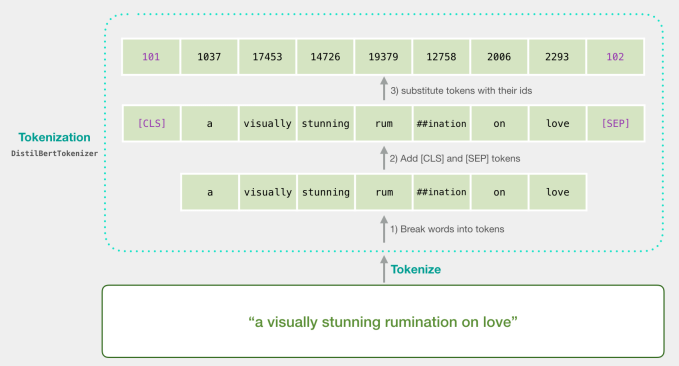


In [25]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    'distilbert-base-uncased',
    do_lower_case=True
)


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    """Tokenize using the Huggingface tokenizer
    Args: 
        sentences: String or list of string to tokenize
        max_length: maximum token length that the tokenizer generates
        padding: Padding method ['do_not_pad'|'longest'|'max_length']
    """
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

def decode(tokens):
    """Decode token ids back to string sequence
    Args:
        tokens: output of the tokenizer having the structure:
                {'input_ids': <tf.Tensor>, 'attention_mask': <tf.Tensor>}
    Returns: List of string sentence
    """
    sentences = []
    for sequence in tokens['input_ids']:
        sentences.append(tokenizer.decode(sequence.numpy().tolist()))

    return sentences

When tokenized, ```i say hello``` (length 3) is padded with a special token ```[PAD]``` to match ```you say good bye``` (length 4). Hence the ```atttention_mask``` for ```i say hello``` has ```0``` at the end as in ```[1, 1, 1, 1, 1, 0]```.

---
# Transfer learning (Fine tuning)


## BERT base model from Huggingface

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

> TFDistilBertModel class to instantiate the base DistilBERT model **without any specific head on top** (as opposed to other classes such as TFDistilBertForSequenceClassification that do have an added classification head). <br><br>
We do not want any task-specific head attached because we simply want the pre-trained weights of the base model to provide a general understanding of the English language, and it will be our job to add our own classification head during the fine-tuning process in order to help the model distinguish between toxic comments.



In [26]:
base = TFDistilBertModel.from_pretrained(
    MODEL_NAME,
)
base.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [27]:
NUM_BASE_MODEL_OUTPUT = 768

In [28]:
test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

## Keras model structure of BERT fine tuning


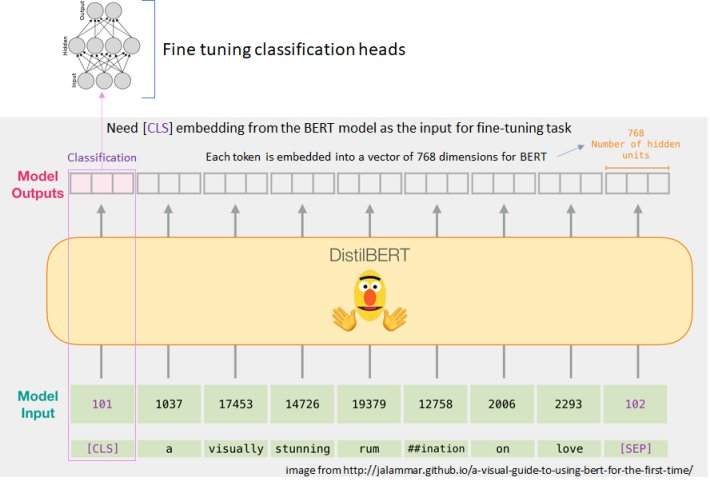


### Text Input layer

The base model expects ```input_ids``` and ```attention_mask``` whose shape is ```(max_sequence_length,)```. Generate Keras Tensors for them with ```Input``` layer respectively and generate the output from the base model. The base model generates ```TFBaseModelOutput```. Feed the embedding of **```[CLS]```** to the next layer.

In [30]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

### Base BERT layer

In [31]:
# TFBaseModelOutput.last_hidden_state has shape (batch_size, max_sequence_length, 768)
# Each sequence has [CLS]...[SEP] structure of shape (max_sequence_length, 768)
# Extract [CLS] embeddings of shape (batch_size, 768) as last_hidden_state[:, 0, :]
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

### Classification layer

In [32]:
if USE_CLASSIFICATION_LAYER:
    # -------------------------------------------------------------------------------
    # Classifiation leayer 01
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dropout(
        rate=0.15,
        name="01_dropout",
    )(output)
    
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="01_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="01_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="01_relu"
    )(output)

    # --------------------------------------------------------------------------------
    # Classifiation leayer 02
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="02_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="02_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="02_relu"
    )(output)

### Output layer


In [33]:
# --------------------------------------------------------------------------------
# TODO:
#    Need to verify the effect of regularizers. 
#
#    [bias regularizer]
#    It looks bias_regularizer adjusts the ROC threshold towards 0.5. 
#    Without it, the threshold of the ROC with BinaryCrossEntropy loss was approx 0.02.
#    With    it, the threshold of the ROC with BinaryCrossEntropy loss was approx 0.6.
# --------------------------------------------------------------------------------
activation = "sigmoid" if NUM_CLASSES == 1 else "softmax"
if USE_SOFTMAX_LAYER:
    LIGITS_TO_LOSS = False
    output = tf.keras.layers.Dense(
        units=NUM_CLASSES,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
        bias_regularizer=tf.keras.regularizers.l2(l2=L2),
        # activity_regularizer=tf.keras.regularizers.l2(l2=L2/10.0),
        activation=activation,
        name=activation
    )(output)

## Keras model

In [34]:
name = f"{TIMESTAMP}_{MODEL_NAME.upper()}"
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name=name)

if NUM_CLASSES == 1:
    METRIC_NAME = "auc"
    MONITOR_METRIC = f"val_{METRIC_NAME}"
    MONITOR_MODE = 'max'
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=LIGITS_TO_LOSS)
    metrics=[tf.keras.metrics.AUC(from_logits=LIGITS_TO_LOSS, name=METRIC_NAME), "accuracy"]
else:
    METRIC_NAME = "accuracy"
    MONITOR_METRIC = "val_loss"
    MONITOR_MODE = 'min'
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=LIGITS_TO_LOSS)
    # metrics=[tf.keras.metrics.Accuracy(name=METRIC_NAME)]
    metrics=["accuracy"]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=loss_fn,
    metrics=metrics
)
model.summary()

Model: "2022MAR29_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None               

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


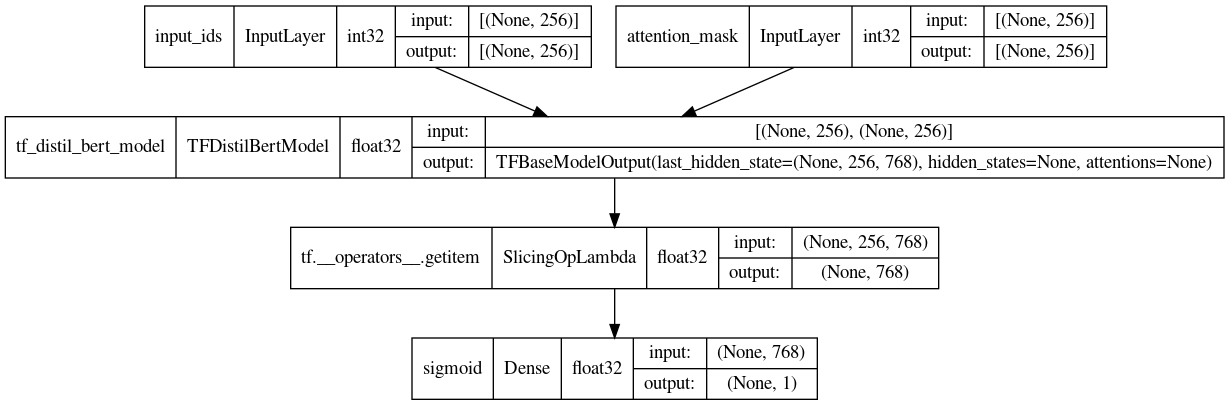

In [35]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

### Model Utilities

In [36]:
def generate_target_predictions(num_classes, index):
    """Extract predictions for the label at the index position.
    With N labels/classes e.g 0, 1, 2 and predictions are [[0.3, 0.2, 0.5]]
    predictions_for_label(3, 1) to extract the prediction '0.2' for the label at index '1'

    For binary classification with sigmoid where num_classes==1, extract [:, 0]
    For binary classification with softmax where num_classes==2, extract [:, 1]

    Args:
        predictions: Tensor or Numpy array of shape (batch_size, num_classes)
        num_classes: Number of labels.
        index: Index of the target predictions.
    Returns: numpy 1D array of predictions at the index [:, index]
    """
    assert 0 <= index < num_classes
    assert index == 0 if num_classes == 1 else ...
    def f(predictions):
        if tf.is_tensor(predictions):
            predictions = predictions.numpy()
        elif isinstance(predictions, np.ndarray):
            pass
        else:
            raise RuntimeError(f"Unexpected prediction type {type(predictions)}")
        
        assert predictions.shape[-1] == num_classes, \
            f"Expected shape is (batch_size, {num_classes}). Got {predictions.shape}"
        
        return predictions[:, index]
        
    return f


get_target_predictions = generate_target_predictions(num_classes=NUM_CLASSES, index=TARGET_LABEL_INDEX)
def predict(model, tokens):
    return get_target_predictions(model.predict(dict(tokens)))


import sklearn.metrics
def evaluate_roc(predictions, labels, title):
    preds = predictions
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, preds)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    # print(f'AUC: {roc_auc:.4f}')

    threshold = thresholds[np.argmax(tpr - fpr)]
    # print(f'Threshold: {threshold:.5f}')
    
    # Get accuracy over the test set
    y_pred = np.where(preds >= threshold, 1, 0)
    accuracy = sklearn.metrics.accuracy_score(labels, y_pred)
    # print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plot ROC AUC
    plt.figure(figsize=(6, 4))
    plt.title(f'{title}')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.grid(which='major', b=False, linestyle='--')
    plt.grid(which='minor', alpha=0.2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # --------------------------------------------------------------------------------
    # Optimal Threshold
    # --------------------------------------------------------------------------------
    return roc_auc, accuracy, threshold

### Model validations

In [37]:
test_model_output = model(test_tokens)
test_predictions = predict(model, test_tokens)
assert test_model_output.shape == (TEST_BATCH_SIZE, NUM_CLASSES)
assert test_predictions.shape == (TEST_BATCH_SIZE,)
assert np.all(0 < test_predictions) and np.all(test_predictions < 1)

### Keras callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [38]:
from sklearn.metrics import roc_auc_score
from keras import backend


class ROCCallback(tf.keras.callbacks.Callback):
    """calculate ROC&AUC
    """
    def __init__(
        self, 
        validation_data, 
        validation_label, 
        output_path, 
        reduce_lr_patiene = 3,
        reduce_lr_factor = 0.2,
        early_stop_patience=sys.maxsize, 
        verbose=True
    ):
        assert 0.0 < reduce_lr_factor < 1.0
        assert 0 < reduce_lr_patiene
        assert 0 < early_stop_patience        

        self.x = validation_data
        self.y = validation_label
        self.output_path = output_path
        self.reduce_lr_patiene = reduce_lr_patiene
        self.reduce_lr_factor = reduce_lr_factor
        self.early_stop_patience = early_stop_patience
        self.verbose = verbose    

        self.max_value = 0
        self.best_epoch = -1
        self.successive_no_improvement = 0
        self.total_no_improvement = 0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def _reduce_learning_rate(self):
        old_lr = backend.get_value(self.model.optimizer.lr)
        new_lr = old_lr * self.reduce_lr_factor
        backend.set_value(self.model.optimizer.lr, new_lr)
        self.successive_no_improvement = 0
        if self.verbose:
            print(f"Reducing learning rate to {new_lr}.")
            
    def _early_stop(self):
        self.model.stop_training = True
        self.total_no_improvement = 0
        if self.verbose:
            print(
                "Early stopping: total no improvement [%s] times. best epoch [%s] AUC [%s]" % 
                (self.total_no_improvement, self.best_epoch, self.max_value)
            )
            
    def on_epoch_end(self, epoch, logs={}):
        # [print(f"{k}:{v}") for k, v in logs.items()]
        predictions = self.model.predict(self.x)
        score = roc_auc_score(self.y, predictions)

        if (self.best_epoch < 0) or (score > self.max_value):
            # --------------------------------------------------------------------------------
            # Save the model upon improvement
            # --------------------------------------------------------------------------------
            if self.verbose:
                print(f"Model auc improved [{score} > {self.max_value:0.5f}]: Saving to {self.output_path}")

            self.max_value = score
            self.best_epoch = epoch
            self.model.save_weights(
                self.output_path, overwrite=True, save_format='h5'
            )

            # Reset counters
            self.successive_no_improvement = 0
            
            # The AUC can not improve than 1.0. Early stop.
            if score > (1.0 - 1e-10):
                self._early_stop()

        else:
            print(f"AUC did not improve from [{self.max_value:0.5f}].")
            # --------------------------------------------------------------------------------
            # Reduce LR
            # --------------------------------------------------------------------------------
            self.successive_no_improvement += 1
            if self.successive_no_improvement >= self.reduce_lr_patiene:
                self._reduce_learning_rate()
                
            # --------------------------------------------------------------------------------
            # Early Stop
            # --------------------------------------------------------------------------------
            self.total_no_improvement += 1
            if self.total_no_improvement >= self.early_stop_patience:
                self._early_stop()
        
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.
    
    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    
    """
    def __init__(self, output_dir, monitor='val_loss', mode='auto', verbose=True):
        super().__init__()
        self.output_dir = output_dir
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose

        self.lowest_val_loss=np.inf
        self.best_epoch = -1
        
    def on_epoch_end(self, epoch, logs={}):
        """
        Save only the best model
        - https://stackoverflow.com/a/68042600/4281353
        - https://www.tensorflow.org/guide/keras/custom_callback
        
        TODO: 
        save_pretrained() method is in the HuggingFace model only.
        Need to implement an logic to update for Keras model saving.
        """
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        
        val_loss=logs.get(monitor)
        if (self.best_epoch < 0) or (val_loss < self.lowest_val_loss):
            if self.verbose:
                print(f"Model val_loss improved: [{val_loss} < {self.lowest_val_loss}]")
                print(f"Saving to {self.output_dir}")
            self.lowest_val_loss = val_loss
            self.best_epoch = epoch
            self.model.save_pretrained(self.output_dir)


class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3, monitor='val_loss', mode='auto'):
        assert patience > 0
        super().__init__(
            monitor=monitor, 
            mode=mode, 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)


class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: 
        Did not work with the HuggingFace native model with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable.
        
        Did not work with the tf.keras.models.save_model nor model.save()
        as causing out-of-index errors or load_model() failures. Hence use
        save_weights_only=True.
    """
    def __init__(self, path_to_file, monitor='val_loss', mode='auto'):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor=monitor, 
            mode=mode, 
            save_best_only=True,
            save_weights_only=True,  # Cannot save entire model.
            save_freq="epoch",
            verbose=1
        )

    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)
        

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3, monitor='val_loss', mode='auto'):
        assert patience > 0
        super().__init__(
            monitor=monitor, 
            mode=mode, 
            factor=0.2,
            patience=patience,
            verbose=1
        )
    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)


---
# Execute BERT fine tuning

## Split data (train & validation) 


In [39]:
# --------------------------------------------------------------------------------
# Split data into training and validation
# --------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(
    train['comment_text'].tolist(),
    train[CATEGORY].tolist(),
    test_size=.2,
    shuffle=True
)

In [40]:
# Convert BatchEncoding to dictionary mapping to TF Tensor. 
# X = dict(tokenize(train_data))
# Y = tf.convert_to_tensor(train_label)
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(train_data)),  # Convert BatchEncoding instance to dictionary
    train_label
)).batch(BATCH_SIZE).prefetch(1)

In [41]:
VT = dict(tokenize(validation_data))  # Convert BatchEncoding instance to dictionary
V = tf.data.Dataset.from_tensor_slices((
    VT,  
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

## Run training

In [42]:
print("""
TEST_MODE= {}
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
L2 = {}
MONITOR_METRIC = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    TEST_MODE,
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    L2,
    MONITOR_METRIC,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY,
))


TEST_MODE= False
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 5e-05
L2 = 0.001
MONITOR_METRIC = val_auc
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = ./output/run_2022MAR29/model
LOG_DIRECTORY = ./output/run_2022MAR29/log



In [43]:
# Load the saved model if exists
if os.path.isfile(MODEL_FILE):
    print(f"loading the saved model parameters from {MODEL_FILE}")
    model.load_weights(MODEL_FILE)

In [44]:
# --------------------------------------------------------------------------------
# Train the model
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# Input data x can be a dict mapping input names to the corresponding array/tensors, 
# if the model has named inputs. Beware of the "names". y should be consistent with x 
# (you cannot have Numpy inputs and tensor targets, or inversely). 
# --------------------------------------------------------------------------------
history = model.fit(
    x=X,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=V,
    callbacks=[
        # EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        # ReduceLRCallback(patience=REDUCE_LR_PATIENCE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        # ModelCheckpointCallback(MODEL_FILE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        ROCCallback(
            validation_data=VT, 
            validation_label=validation_label, 
            output_path=MODEL_FILE, 
            reduce_lr_patiene = REDUCE_LR_PATIENCE,
            reduce_lr_factor = 0.2,
            early_stop_patience=EARLY_STOP_PATIENCE, 
            verbose=True
        ),
        #TensorBoardCallback(LOG_DIRECTORY)
    ]
)

Epoch 1/5
6883/6883 [==============================] - 6003s 871ms/step - loss: 0.1031 - auc: 0.9924 - accuracy: 0.9634 - val_loss: 0.0639 - val_auc: 0.9962 - val_accuracy: 0.9795
Epoch 2/5
6883/6883 [==============================] - 6142s 892ms/step - loss: 0.0376 - auc: 0.9981 - accuracy: 0.9889 - val_loss: 0.0851 - val_auc: 0.9944 - val_accuracy: 0.9786
Epoch 3/5
6883/6883 [==============================] - 6006s 873ms/step - loss: 0.0209 - auc: 0.9991 - accuracy: 0.9941 - val_loss: 0.0502 - val_auc: 0.9962 - val_accuracy: 0.9871
Epoch 4/5
6883/6883 [==============================] - 6163s 895ms/step - loss: 0.0141 - auc: 0.9994 - accuracy: 0.9961 - val_loss: 0.0420 - val_auc: 0.9969 - val_accuracy: 0.9894
Epoch 5/5
6883/6883 [==============================] - ETA: 0s - loss: 0.0109 - auc: 0.9996 - accuracy: 0.9969AUC did not improve from [0.99829].
Reducing learning rate to 9.999999747378752e-06.
6883/6883 [==============================] - 6085s 884ms/step - loss: 0.0109 - auc: 0

---
# Evaluation

In [47]:
tokens = dict(tokenize(test['comment_text'].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((
    tokens,
    test[CATEGORY]
))
evaluation = model.evaluate(
    test_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(1)
)
print(f"evaluation({model.metrics_names})={evaluation}")

2000/2000 [==============================] - 537s 268ms/step - loss: 0.4096 - auc: 0.9210 - accuracy: 0.9257
evaluation(['loss', 'auc', 'accuracy'])=[0.40961185097694397, 0.9210350513458252, 0.9256775975227356]


## ROC/AUC

<img src="./image/AUC.jpg"/>

In [48]:
probabilities = predict(model, tokens)

/tmp/ipykernel_3841/3067536625.py:59: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(which='major', b=False, linestyle='--')
/tmp/ipykernel_3841/3067536625.py:59: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(which='major', b=False, linestyle='--')


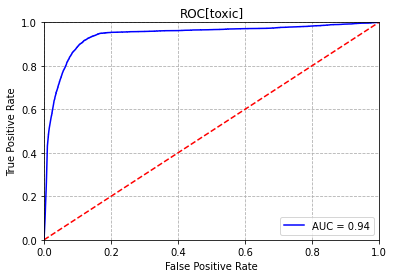

0.0023929337


In [49]:
roc_auc, accuracy, threshold = evaluate_roc(probabilities, test[CATEGORY], f"ROC[{CATEGORY}]")
print(threshold)

## Recall

In [50]:
# predictions = np.argmax(model.predict(tokens), axis=-1)
predictions = np.reshape(probabilities >= threshold, (-1, 1)).astype(int)
test['prediction'] = predictions
test.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,prediction
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0,1


In [51]:
print(f"Threshold[{CATEGORY}] {threshold}")

# NP: Negative Predictions
# PP: Positive Predictions
PP = test[(test['prediction'] > threshold)]['id'].count()
NP = test[(test['prediction'] <= threshold)]['id'].count()
ALL = PP + NP

# TP: True Positive Prediction
# AP: Actual Positive
# TN: True Negative Prediction
# AN: Actual Negative
TP = test[(test[CATEGORY] == 1) & (test['prediction'] > threshold)]['id'].count()
AP = test[(test[CATEGORY] == 1)]['id'].count()
TN = test[(test[CATEGORY] == 0) & (test['prediction'] <= threshold)]['id'].count()
AN = test[(test[CATEGORY] == 0)]['id'].count()

print(f"[{CATEGORY:13s}] TP {TP/ALL:0.3f} FP {(PP-TP)/ALL:0.3f} TN: {TN/ALL:0.3f} FN {(NP-TN)/ALL:0.3f}" ) 
if AP > 0:
    print(f"[{CATEGORY:13s}] True Positive Rate (Recall) : {TP/AP:0.3f}" ) 
if PP > 0:
    print(f"[{CATEGORY:13s}] Positive Precision          : {TP/PP:0.3f}" ) 
if AN > 0:
    print(f"[{CATEGORY:13s}] Specificity                 : {TN/AN:0.3f}") 
if NP > 0:
    print(f"[{CATEGORY:13s}] Negative Precision          : {TN/NP:0.3f}" ) 
if True:
    print(f"[{CATEGORY:13s}] Accuracy                    : {(TP+TN)/ALL:0.3f}" ) 

Threshold[toxic] 0.002392933703958988
[toxic        ] TP 0.087 FP 0.108 TN: 0.797 FN 0.008
[toxic        ] True Positive Rate (Recall) : 0.916
[toxic        ] Positive Precision          : 0.447
[toxic        ] Specificity                 : 0.881
[toxic        ] Negative Precision          : 0.990
[toxic        ] Accuracy                    : 0.884
